## Project Overview
*A structured approach* to compare Logistic Regression and XGBoost on loan approval prediction data. 
Each stage below can be implemented in a single Jupyter notebook or modular Python scripts.

## 1. Define the Objective

* Binary classification: predict Loan_Status (Approved/Denied).

* Compare Logistic Regression (interpretability, speed) vs. XGBoost (complexity, accuracy).

* Evaluation dimensions: accuracy, interpretability, deployment readiness.

## 2. Acquire the Dataset

* Download the “Loan Prediction” dataset from Kaggle (CSV format).

* Ensure inclusion of:

    * Numeric features: ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term

    * Categorical: Gender, Married, Education, Self_Employed, Property_Area, Credit_History

    * Target: Loan_Status

In [1]:
pip install -r requirements.txt



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 3. Exploratory Data Analysis (EDA)

* Distributions

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: title={'center': 'loan_status'}, xlabel='loan_status', ylabel='count'>

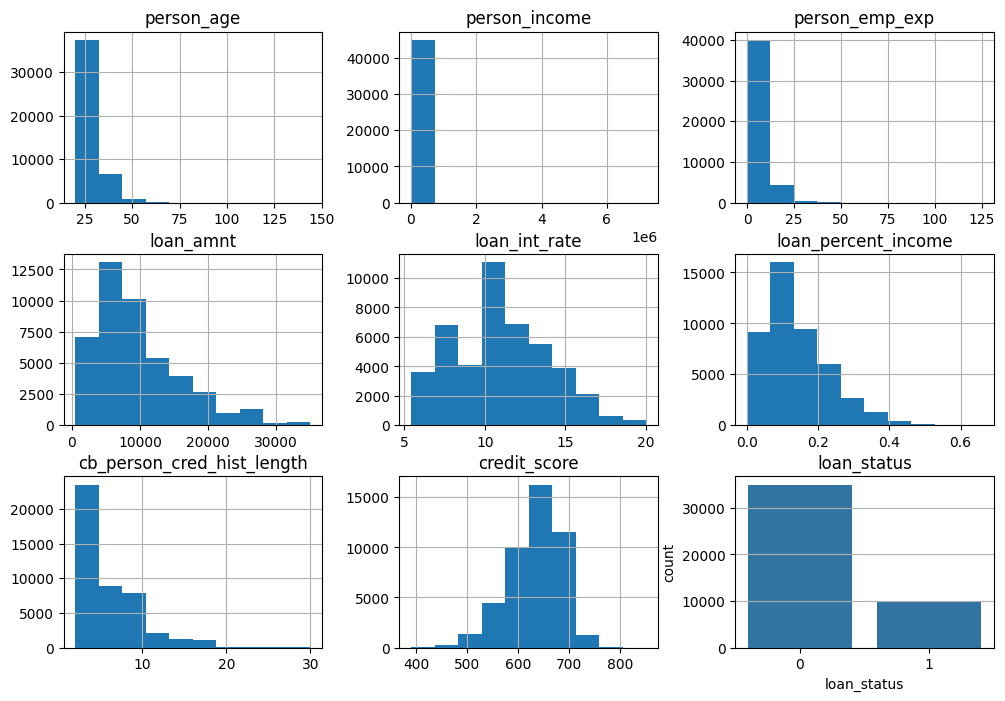

In [3]:
loan_df = pd.read_csv("loan_data.csv")

loan_df.hist(figsize=(12,8))
sns.countplot(x="loan_status", data=loan_df)


In [4]:
loan_df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
loan_df.isna().sum()


person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

## 4. Data Preprocessing

1. *Handle missing values*

    * Numeric: mean/median; Categorical: mode or “Unknown” tag.

2. *Encode categorical variables*

    * OneHotEncoder or pd.get_dummies.

3. *Normalize/scale numeric features*

    * StandardScaler or MinMaxScaler for Logistic Regression; XGBoost handles raw values but scaling improves comparability.

4. *Class imbalance*

    * Check Loan_Status distribution.

    * Use SMOTE (*imblearn.over_sampling*.SMOTE) or class weighting (*class_weight='balanced'* in LogisticRegression) if needed.

**Scale features**
PCA assumes features are on the same scale. Reason why we need to first perform feature scaling. 

### Separate features and target

In [6]:
X = loan_df.drop("loan_status", axis=1)
y = loan_df["loan_status"]


### Define preprocessing transformers

In [7]:
numeric_cols = X.select_dtypes(include="number").columns
categorical_cols = X.select_dtypes(exclude="number").columns
numeric_cols


Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [9]:
X_preprocessed = preprocessor.fit_transform(X)


## Perform PCA for Feature Selection

This step is only useful when you have too many features and want to select the best for your model.
I will show how you could perform this here but given how small and clean the dataset used here is, 
I won't need to to feature selection. This would the to first step for feature engineering.

In [10]:
from sklearn.decomposition import PCA
pca = PCA()                     # or PCA(n_components=desired_number)
X_pca = pca.fit_transform(X_preprocessed)


## Split the data into train - test

In [11]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42
)



## 5. Train Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, RocCurveDisplay

log_reg = LogisticRegression(max_iter=500, solver="liblinear")
param_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_lr = GridSearchCV(log_reg, param_grid, scoring="f1", cv=cv)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_


## 6. Train XGBoost

In [13]:


xgb = XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", use_label_encoder=False
)
param_grid = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1.0],
}
grid_xgb = GridSearchCV(xgb, param_grid, scoring="f1", cv=5)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site

## 7. Evaluate Model Performance

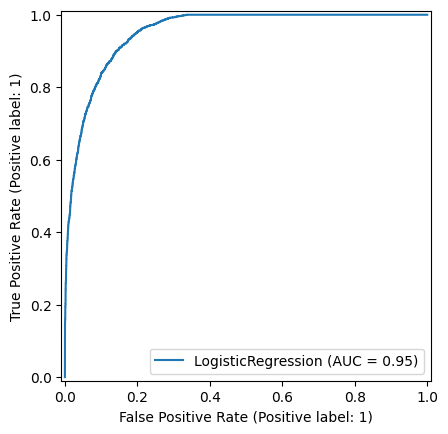

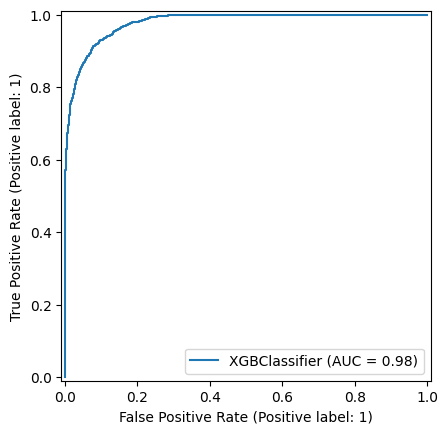

In [14]:


def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary")
    auc = roc_auc_score(y_test, proba)
    cm = confusion_matrix(y_test, preds)
    return acc, prec, rec, f1, auc, cm

results_lr = evaluate(best_lr, X_test, y_test)
results_xgb = evaluate(best_xgb, X_test, y_test)

RocCurveDisplay.from_estimator(best_lr, X_test, y_test)
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)


In [15]:

preds = best_lr.predict(X_test)
cm_normalized = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Denied", "Approved"])

NameError: name 'ConfusionMatrixDisplay' is not defined

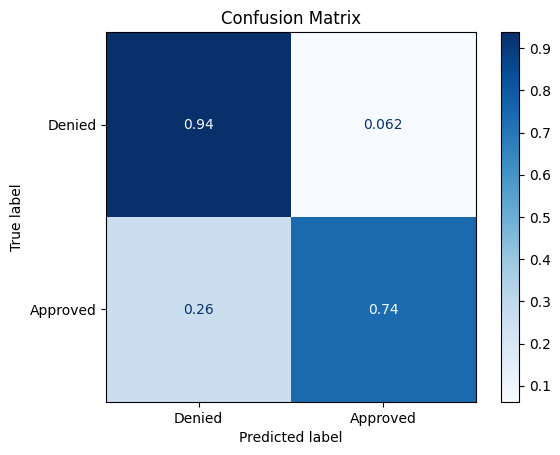

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Denied", "Approved"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
other_metrics = evaluate(best_lr, X_test, y_test)
print(other_metrics)

(0.8941111111111111, 0.7745454545454545, 0.7417910447761195, 0.7578144853875477, 0.9526776703037033, array([[6556,  434],
       [ 519, 1491]]))


## 8. Analyze Interpretability

* Logistic Regression

    * Examine coefficients:

In [ ]:
coef_df = pd.DataFrame(
    {"feature": X_train.columns, "coef": best_lr.coef_[0]}
).sort_values("coef", ascending=False)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

* XGBoost

    * Feature importance: best_xgb.feature_importances_

    * SHAP values:

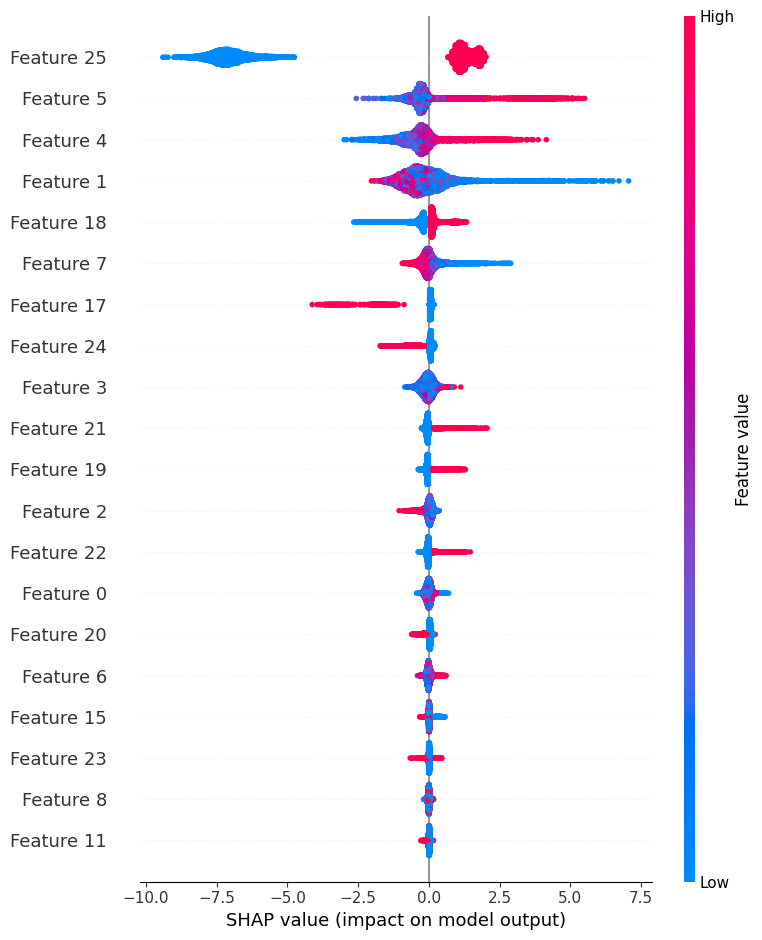

In [ ]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
